In [1]:
from FlightRadar24 import FlightRadar24API
from dotenv import load_dotenv
import os
import math
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
load_dotenv()

True

In [3]:
fr_api = FlightRadar24API(user=os.getenv("fr_uname"), password=os.getenv("fr_pwd"))

In [4]:
#Possible methods
fr_api.get_airlines()
fr_api.get_airports()
fr_api.set_flight_tracker_config()
flights_ibe = fr_api.get_flights(airline = "IBE") # Example searching for iberia
flights = fr_api.get_flight_details(flights_ibe[1])
flights["trail"]


[{'lat': 43.337296,
  'lng': -85.742928,
  'alt': 31625,
  'spd': 387,
  'ts': 1699300756,
  'hd': 229},
 {'lat': 43.376026,
  'lng': -85.681587,
  'alt': 32175,
  'spd': 386,
  'ts': 1699300723,
  'hd': 229},
 {'lat': 43.415409,
  'lng': -85.618614,
  'alt': 32725,
  'spd': 387,
  'ts': 1699300689,
  'hd': 229},
 {'lat': 43.454544,
  'lng': -85.55584,
  'alt': 33275,
  'spd': 386,
  'ts': 1699300655,
  'hd': 229},
 {'lat': 43.487366,
  'lng': -85.502762,
  'alt': 33775,
  'spd': 383,
  'ts': 1699300627,
  'hd': 229},
 {'lat': 43.524529,
  'lng': -85.442764,
  'alt': 34250,
  'spd': 390,
  'ts': 1699300595,
  'hd': 229},
 {'lat': 43.563213,
  'lng': -85.380051,
  'alt': 34800,
  'spd': 391,
  'ts': 1699300562,
  'hd': 229},
 {'lat': 43.601669,
  'lng': -85.317719,
  'alt': 35375,
  'spd': 387,
  'ts': 1699300529,
  'hd': 229},
 {'lat': 43.605015,
  'lng': -85.312302,
  'alt': 35425,
  'spd': 386,
  'ts': 1699300526,
  'hd': 229},
 {'lat': 43.608627,
  'lng': -85.306473,
  'alt': 35475,

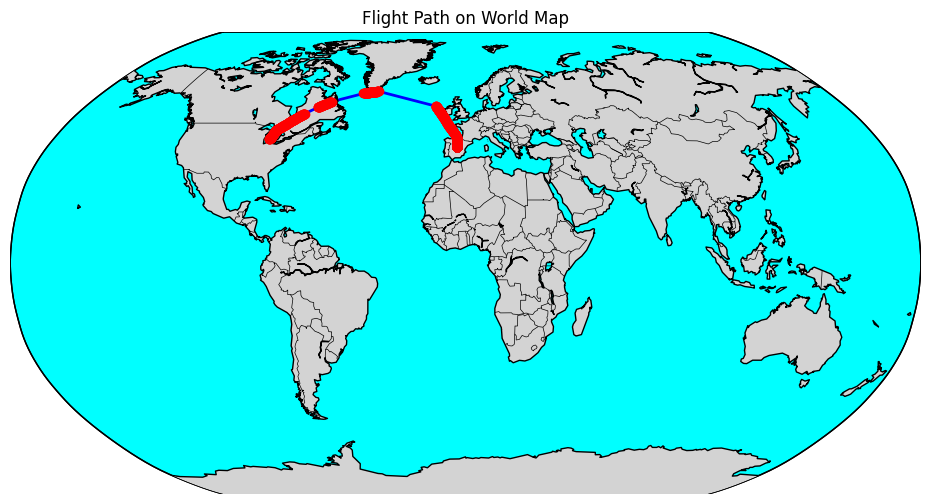

In [5]:
flight_data = flights["trail"]

# Extracting latitude and longitude from the data
lats = [point['lat'] for point in flight_data]
lngs = [point['lng'] for point in flight_data]

# Creating a Basemap instance
plt.figure(figsize=(12, 6))
world_map = Basemap(projection='robin', lat_0=0, lon_0=0, resolution='c')

# Converting lat and lon to map projection coordinates for the world map
x_world, y_world = world_map(lngs, lats)

# Plotting the points on the world map
world_map.plot(x_world, y_world, marker='o', markersize=5, color='b', linewidth=2)
world_map.scatter(x_world, y_world, marker='o', color='r', zorder=5)
world_map.drawcoastlines()
world_map.drawcountries()
world_map.fillcontinents(color='lightgray',lake_color='aqua')
world_map.drawmapboundary(fill_color='aqua')

# Adding title and showing the plot
plt.title('Flight Path on World Map')
plt.show()
# Creating plots with Orthographic and Mollweide projections as alternative


# Example for our project

In [6]:
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles, Popup, Polygon
from ipywidgets import HTML

In [7]:
class Coord:
    """Class to handle coordinates in EPSG:3857"""
    def __init__(self, lat:float, long:float ):
        """Initializes the class with some coordinates in EPSG:3857"""""
        self.long = long
        self.lat = lat
    
    # def build_rectangle(self, degrees:float=0.6):
    #     self.two_points = self._get_api_2_points()
    #     self.corners = self._get_corners()
        
    def get_api_2_points(self, degrees: float = 0.6) -> str:
        """ Returns coordinates in the format y1,y2,x1,x2 as per the API """
        # lat_wgs84, long_wgs84 = self.to_wgs84()
        # y1 = lat_wgs84 + degrees / 2
        # y2 = lat_wgs84 - degrees / 2
        # x1 = long_wgs84 + degrees / 2
        # x2 = long_wgs84 - degrees / 2
        y1 = self.lat + degrees / 4
        y2 = self.lat - degrees / 4
        x1 = self.long - degrees / 2
        x2 = self.long + degrees / 2
        return f"{y1},{y2},{x1},{x2}"
    
    def get_corners(self, degrees:float=0.6)-> list[float]:
        """Returns a list of tuples containing the corners of the rectangle"""
        # Calculate the corners of the rectangle
        top_left = (self.lat + degrees/4, self.long - degrees/2)
        top_right = (self.lat + degrees/4, self.long + degrees/2)
        bottom_left = (self.lat - degrees/4, self.long - degrees/2)
        bottom_right = (self.lat - degrees/4, self.long + degrees/2)
        
        # Return the corners as a list of tuples
        return [top_left, top_right, bottom_right, bottom_left]

    def _to_wgs84(self):
        """ Conversion from EPSG:3857 to EPSG:4326 """
        x = self.long
        y = self.lat
        lon = x / 20037508.34 * 180.0
        lat = y / 20037508.34 * 180.0
        lat = 180 / math.pi * (2 * math.atan(math.exp(lat * math.pi / 180)) - math.pi / 2)

        return lat, lon

## Description
What we do is click on the map to select a point. This simulates finding a location.  
We then build a bounding box surrounding this point (default 0.6 degrees side length in longitude)

In [8]:
def handle_click(**kwargs):
    global current_marker
    global current_square
    global coordinates
    if kwargs.get('type') == 'click':
        coords = kwargs.get('coordinates')
        print(f"Clicked coordinates: {coords}")

        # Remove the current marker if it exists
        if current_marker is not None:
            m.remove_layer(current_marker)

        # Remove the current square if it exists
        if current_square is not None:
            m.remove_layer(current_square)
        html = HTML()
        html.value = f"Lat, Long: {coords[0]:.5f}, {coords[1]:.5f}"
        # Create and add a new marker
        new_marker = Marker(location=coords)
        current_marker = new_marker
        popup = Popup(location=coords, child=html, close_button=False, auto_close=False, close_on_escape_key=False)
        current_marker.popup = popup
        m.add_layer(current_marker)

        # Logic for creating and adding a square
        coordinates = Coord(coords[0], coords[1])
        corners =  coordinates.get_corners(degrees=0.4) # Assuming this function returns the correct corners
        square = Polygon(
            locations=corners,
            color="green",
            fill_color="green"
        )
        current_square = square
        m.add_layer(current_square)

In [9]:
current_marker = None
current_square = None
coordinates = None

m = Map(
    basemap=basemap_to_tiles(basemaps.CartoDB.Positron, day="today"),
    center=(59.3, 18),
    zoom=8
)

# Add click event listener to the map
m.on_interaction(handle_click)

# Display the map
m

Map(center=[59.3, 18], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Clicked coordinates: [55.52863052257191, 11.909179687500002]
Clicked coordinates: [55.598523085310305, 11.906433105468752]


In [13]:
# We take the selected coordinate
coord = coordinates.get_api_2_points(degrees=1)
coord

'55.848523085310305,55.348523085310305,11.406433105468752,12.406433105468752'

In [14]:
flights = fr_api.get_flights(bounds=coord)

In [15]:
flights

[<(A20N) EI-SIP - Altitude: 13000 - Ground Speed: 343 - Heading: 92>,
 <(B38M) SE-RTF - Altitude: 7800 - Ground Speed: 372 - Heading: 55>]

In [ ]:
flight_details =[]
for i,flight in enumerate(flights):
    _details = fr_api.get_flight_details(flight)
    flight_details.append(_details)
    

In [ ]:
flight_details[0]

In [ ]:
for fd in flight_details:
    trail = fd["trail"]
    lats = [point['lat'] for point in trail]
    lngs = [point['lng'] for point in trail]

    # Creating a Basemap instance
    plt.figure(figsize=(12, 6))
    # world_map = Basemap(projection='robin', lat_0=0, lon_0=0, resolution='c')
    world_map = Basemap(projection='ortho', lat_0=trail[0]['lat'], lon_0=trail[0]['lng'], resolution='c')

    # Converting lat and lon to map projection coordinates for the world map
    x_world, y_world = world_map(lngs, lats)

    # Plotting the points on the world map
    world_map.plot(x_world, y_world, marker='o', markersize=5, color='b', linewidth=2)
    world_map.scatter(x_world, y_world, marker='o', color='r', zorder=5)
    world_map.drawcoastlines()
    world_map.drawcountries()
    world_map.fillcontinents(color='lightgray',lake_color='aqua')
    world_map.drawmapboundary(fill_color='aqua')

    # Adding title and showing the plot
    plt.title(f'Flight Path on World Map for flight{fd["identification"]["number"]["default"]} \n Origin: {fd["airport"]["origin"]["code"]["iata"]} - Destination: {fd["airport"]["destination"]["code"]["iata"]}')
    plt.show()

In [ ]:
# Sadly this example is just a short route and therefore the projection is not very good